## Lecture 3

#### Announcements

* Feedback for P01 and P02 came back yesterday.
    * Please typset your answers and submit to Gradescope in PDF format by Sunday night of the week they are assigned.
    * If you wish to submit or or resubmit anytime after 7am Monday morning after the deadline, please submit via Gradescope then send me an email to let me know that you've done so. I will give timely feedback on late and re-submissions on a best-effort basis.
 
* Project 1 is out today.

* Let's discuss: **Feedback on homework -- helpful?**

* Let's discuss: **Final exam vs Final project**?

#### Goals
* Image Derivatives:
    * Know how to compute image derivatives using convolution filters
    * Understand how to derive and apply the the Sobel edge detection filter
* Spatial Frequency:
    * Have an intuitive understanding of spatial frequency in images
    * Know the meaning and construction of "low pass" and "high pass" filters
* Resizing Images:
    * Know how to make images smaller:
      * The naive way via subsampling (and why this is bad)
      * The principled way by downsampling with prefiltering (and why this is better)
    * Know how to make images bigger

In [ ]:
# boilerplate setup
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
import sys

src_path = os.path.abspath("../src")
if (src_path not in sys.path):
    sys.path.insert(0, src_path)

# Library imports
import numpy as np
import imageio.v3 as imageio
import matplotlib.pyplot as plt
import skimage as skim
import cv2

# codebase imports
import util
import filtering

#### Differentiating Images

Images are functions; differentiation is an operator. What does it mean?

Since they're functions of two variables, a single-valued output needs to be a partial derivative:
* Horizontal ($x$) derivative: $\frac{\partial}{\partial x}  f(x, y)$
* Vertical ($y$) derivative: $\frac{\partial}{\partial y}  f(x, y)$

We have discrete (i.e., sampled) images, so we need to approximate this with finite differences. Let's design a convolution kernel that accomplishes this.

Whiteboard: calculus reminder

##### Homework Problem 1

Consider the following two candidate horizontal derivative filters.
$$
\begin{bmatrix}
  1 & -1 & 0\\
  \end{bmatrix}
$$

$$
\begin{bmatrix}
  1 & 0 & -1\\
  \end{bmatrix}
$$

  1. Why is the negative number to the right of the positive one?
  2. If we wanted to accurately calculate the slope with correct scale, how would we need to modify the above kernels?
  3. What are the relative merits of each of these filters?

In [ ]:
bikes = imageio.imread("../data/bikesgray.jpg").astype(np.float32) / 255.0
bikes = skim.transform.rescale(bikes, 0.5, anti_aliasing=True)
bikes = bikes + np.random.randn(*bikes.shape) * 0.05

util.imshow_gray(bikes)

In [ ]:
dx = np.array([-1, 0, 1]).reshape((1, 3)) / 2
dy = dx.T

**Reference link:** fancy [slicing](https://numpy.org/doc/stable/user/basics.indexing.html) in numpy

**Look at `filtering.py`**
* I tweaked our `filter` function to handle non-square kernels.
* I added a `convolve` that just flips the kernel then runs `filter`

In [ ]:
bx = filtering.filter(bikes, dx)
by = filtering.filter(bikes, dy)

util.imshow_gray(np.hstack([bx, by]))

In [ ]:
util.imshow_gray(np.hstack([bx[30:80, :50], by[30:80, :50]]))

Let's look at the intensities along a single scanline. This one is a vertical scanline that crosses the brick pattern.

In [ ]:
plt.plot(bikes[:,100])

In [ ]:
plt.plot(by[:,100])

This motivates an idea: blur the noise so that the real edges stick out!

Why use 2 filters when you could use just 1?

##### Homework Problem 2

Compute the following convolution, which results in a new filter kernel, and describe the effect of this new kernel in words.
   $$
   \begin{bmatrix}
     1 & 2 & 1\\
     2 & 4 & 2\\
     1 & 2 & 1
   \end{bmatrix} *
   \begin{bmatrix}
     0 & 0 & 0\\
     1 & 0 & -1\\
     0 & 0 & 0
   \end{bmatrix} = 
   \begin{bmatrix}
     \  & \ & \ \\
     \ & \ & \ \\
     \hspace{1em} & \hspace{1em} & \hspace{1em}
   \end{bmatrix}
   $$

Let's check our work:

In [ ]:
blur = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]], dtype=np.float32)

dx = np.array([
    [0, 0,  0],
    [1, 0, -1],
    [0, 0,  0]], dtype=np.float32)

# check our answer
xsobel = filtering.convolve(blur, dx)
ysobel = xsobel.T
xsobel

For whatever reason, this is more often written scaled down by 1/2:

In [ ]:
xsobel /= 2
ysobel = xsobel.T
xsobel, ysobel

In [ ]:
bx = filtering.convolve(bikes, xsobel)
by = filtering.convolve(bikes, ysobel)

util.imshow_gray(np.hstack([bx, by]))

In [ ]:
plt.plot(by[:,100])

### From sobel to edge detection

Direction-independent edge detector?
First pass: gradient magnitude

$$ \Delta f =
\begin{bmatrix}
\frac{\partial}{\partial x}  f \\
\frac{\partial}{\partial y}  f
\end{bmatrix}
$$
Edge strength: gradient magnitude $||\Delta f||$

In [ ]:
plt.imshow(np.sqrt(bx ** 2 + by**2), cmap="gray")

This is useful enough that I wrote `filtering.grad_mag` to make it simple to do.

In [ ]:
util.imshow_gray(filtering.grad_mag(bikes))

Classical fancier method: **Canny Edge Detector**
[[wiki]](https://en.wikipedia.org/wiki/Canny_edge_detector#Walkthrough_of_the_algorithm)
[[opencv docs]](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga04723e007ed888ddf11d9ba04e2232de)
[[opencv tutorial]](https://docs.opencv.org/3.4/da/d22/tutorial_py_canny.html)
* Convert to grayscale
* Blur with 5x5 $\sigma=1.4$ Gaussian
* Calculate gradient magnitude
* Apply non-maximum suppression
* Threshold with 2 cutoffs for strong edges, weak edges, and non-edges
* Preserve only weak edges that connect to strong edges

In [ ]:
# opencv wants 8-bit images
bikes_uint8 = (bikes * 255).astype(np.uint8)
util.imshow_gray(np.hstack([
    filtering.grad_mag(bikes), 
    util.byte2float(cv2.Canny(bikes_uint8, 100, 200))
]))

## Spatial Frequency

Whiteboard - intuition (only) for the Fourier decomposition

In [ ]:
def cos_image(dims, fx, fy):
    img = np.zeros(shape=dims)
    for iy in range(dims[0]):
        for ix in range(dims[1]):
            img[iy, ix] = np.cos(ix / dims[1] * fx * np.pi) * np.cos(iy / dims[0] * fy * np.pi)
    return img

img = cos_image([100, 200], 1, 0)
plt.imshow(img, cmap='gray');

In [ ]:
img = (
    0.2  * cos_image([100, 200], 0, 0) + 
    0.4  * cos_image([100, 200], 3, 1) + 
    0.1  * cos_image([100, 200], 7, 20) + 
    0.1  * cos_image([100, 200], 12, 19) + 
    0.25 * cos_image([100, 200], 30, 85) + 
    0.05 * cos_image([100, 200], 40, 97)
)
plt.imshow(img, cmap='gray');

Let's zoom in to our picture of beans. Some areas are mostly low frequency, and some have a lot of higher frequency content.

In [ ]:
beans = imageio.imread("../data/beans.jpg").astype(np.float32) / 255.0
bg = skim.color.rgb2gray(beans) # grayscale beans

plt.imshow(beans)

In [ ]:
plt.imshow(beans[400:500, 100:200])

In [ ]:
plt.imshow(beans[20:120, 500:600])

In [ ]:
plt.imshow(beans[420:480, 550:600])

## Break, if we haven't already taken one!

#### Definitions: "Low-Pass" and "High-Pass" filters

Low-pass: allows low frequencies to pass through unaffected, i.e., attenuates high frequencies.
* In other words: blur!

High-pass: allows high frequencies to pass through unaffected, i.e., attenuates low frequencies.
* In other words: derivative, (with slight but common terminology abuse) sobel, or  sharpening

Question that didn't make it onto the homework: in what sense is Sobel not truly a high-pass filter?

##### Homework Problems 3-6

(3) Using the language of "low-" and "high-frequency" image content, explain why sharpening is not the inverse of blurring, and what it accomplishes instead.

(4) Consider the original image of beans on the left, and the processed version on the right. Describe what has changed in terms of frequency content.

   ![](../data/beans_frequency.jpg)
   
(5) What's the **maximum** frequency (expressed in full periods per pixel) representable in a 1D image (i.e., a row of pixels)? What does such an image look like?

(6) What's the **minimum** frequency representable in a 1D image? What does such an image look like?

### Downsampling

My image is too big to fit on my screen. For example, suppose beans is 600x600, but I want to display the image in 300x300 pixels. What should I do?

In [ ]:
bg.shape # beans grayscale

In [ ]:
util.imshow_truesize(bg[::2,::2])

In [ ]:
bricks = imageio.imread("../data/bricks.jpg").astype(np.float32) / 255.0
plt.imshow(bricks[::4,::4,:])

In [ ]:
checker = np.zeros((1, 16))
checker[:, ::2] = 1.0
util.imshow_gray(checker)

In [ ]:
plt.imshow(checker[:, ::2], vmin=0, vmax=1, cmap="gray") # force color scale to [0,1] range

##### Homework Problem 7

If you walked far away from the above image until you couldn't distinguish individual pixels, what would it look like?

In [ ]:
# todo: implement filtering.down_2x

In [ ]:
util.imshow_truesize(bg[::4,::4])

In [ ]:
# todo: implement down_2x
util.imshow_truesize(filtering.down_4x(bg))

### Upsampling

My image is too small for my screen. For example, suppose beans is 150x150, but I want to display the image in 600x600 pixels. What should I do?

In [ ]:
beans150 = filtering.down_4x(bg)
util.imshow_truesize(beans150)

See naive version preimplemented in `filtering.up_2x`

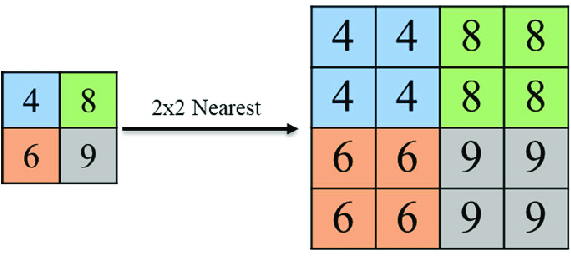

In [ ]:
util.imshow_truesize(filtering.up_4x(beans150, interp="nn"))

**Whiteboard:** Filtering view of upsampling

In [ ]:
# todo: implement reconstruction filtering version in up_2x
# - Gaussian reconstruction filter
# - Linear reconstruction filter
util.imshow_truesize(filtering.up_4x(beans150, interp="gaussian"))